# Синтезирование лиц из LFW с помощью DCGAN

## Переключение версии TensorFlow

In [0]:
%tensorflow_version 2.x

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

## Загрузка и подготовка датасета

In [0]:
data = tfds.load('lfw', split='train', shuffle_files=True, data_dir="/content/data/")

In [0]:
data = data.shuffle(1000).batch(2000).prefetch(1)
for features in tfds.as_numpy(data):
  train_x = features['image']

In [5]:
train_x.shape

(1233, 250, 250, 3)

In [0]:
train_x = (train_x.reshape(-1, 250*250*3).astype(np.float32) - 127.5) / 127.5

In [9]:
print(train_x.shape, train_x.dtype)
print(np.min(train_x), np.max(train_x))

(1233, 187500) float32
-1.0 1.0


## Визуализация датасета LFW

In [0]:
def plot_digits(samples):
    fig = plt.figure(figsize=(20, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(4, 8, j+1)
        ax.imshow(samples[j, ...].reshape(250, 250, 3))
        plt.xticks([]), plt.yticks([])
    plt.show()

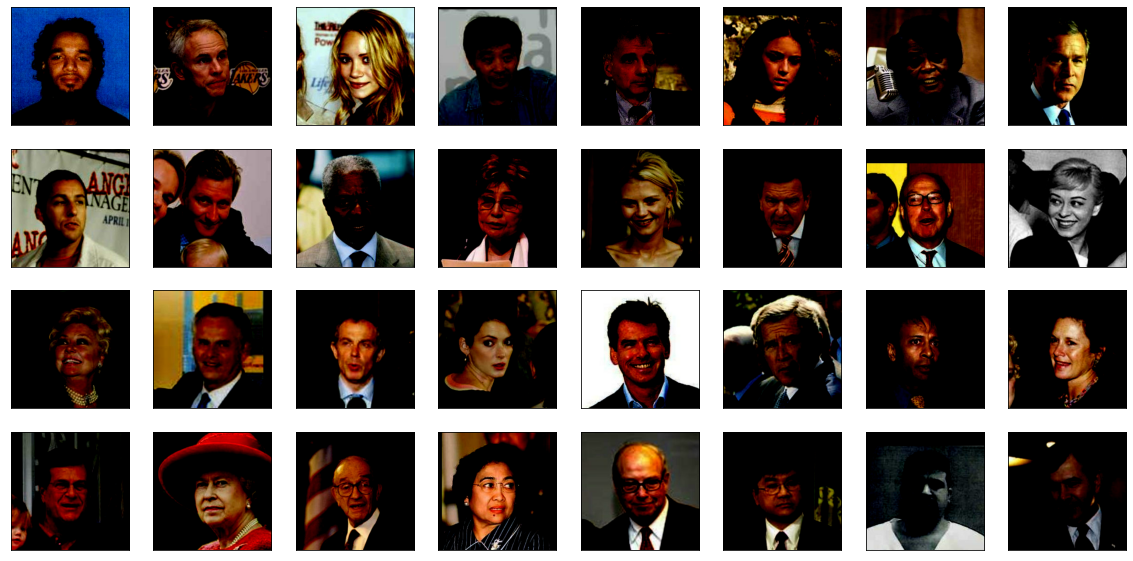

In [37]:
import logging # To switch off warnings

logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

plot_digits(train_x[:32, ...])

logger.setLevel(old_level)

## Подготовка пайплайна данных и оптимизатора

In [0]:
INPUT_DIM = 100
NUM_EPOCHS = 2
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 0.0002

train_ds = tf.data.Dataset.from_tensor_slices(train_x.reshape(-1, 250, 250, 3))
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Обучение DCGAN

In [0]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(128*25*25, activation='relu'),
    tf.keras.layers.Reshape((25, 25, 128)),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(0.2),    
    tf.keras.layers.UpSampling2D((5, 5)),    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(0.2),    
    tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='tanh'),
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

[Step  0] D Loss: 0.5493; G Loss: 12.0875


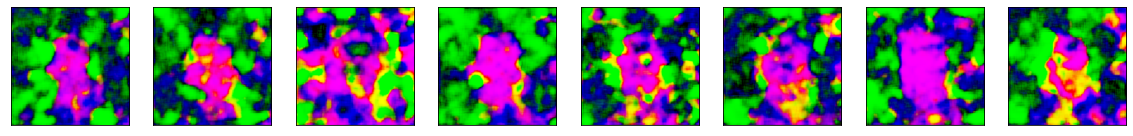

[Step 20] D Loss: 0.1057; G Loss: 15.7908


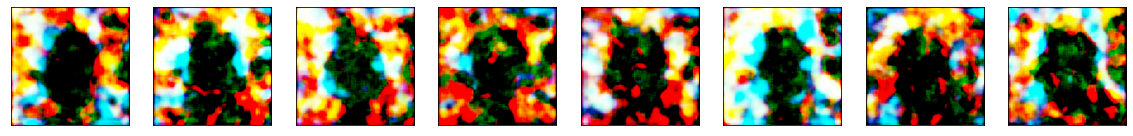

[Step 40] D Loss: 0.0055; G Loss: 22.3622


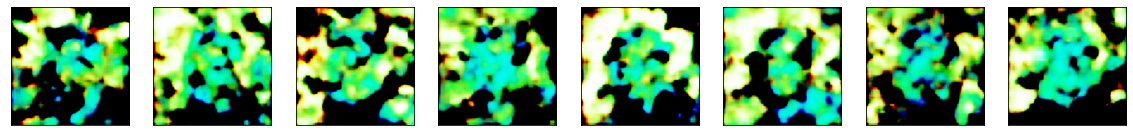

[Step 60] D Loss: 0.0000; G Loss: 12.4073


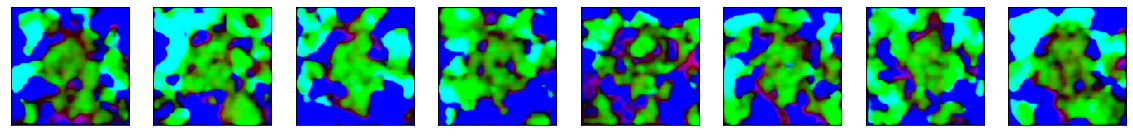

[Step 80] D Loss: 0.0006; G Loss: 31.8736


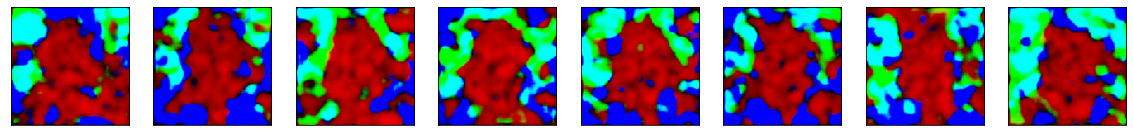

[Step 100] D Loss: 0.4454; G Loss: 18.7064


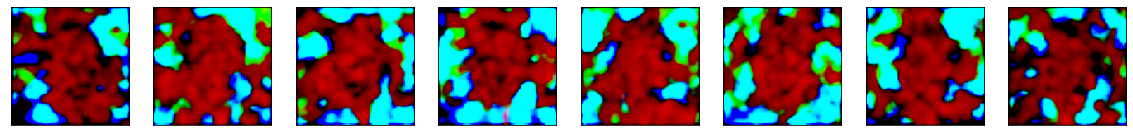

[Step 120] D Loss: 0.6075; G Loss: 31.1580


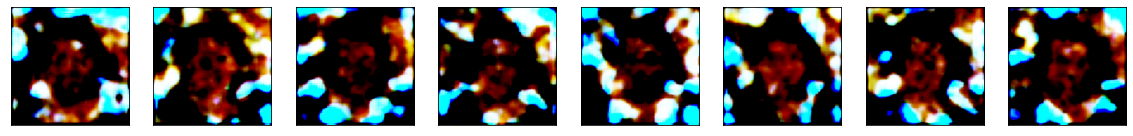

[Step 140] D Loss: 3.4985; G Loss: 36.2860


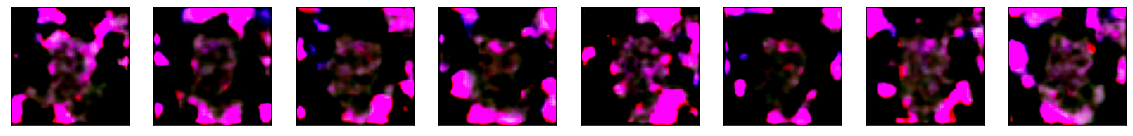

In [61]:
for step, true_images in enumerate(train_ds):
    
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    
    if step % 20 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_digits(syntetic_images)


## Тестирование свёрточного генератора

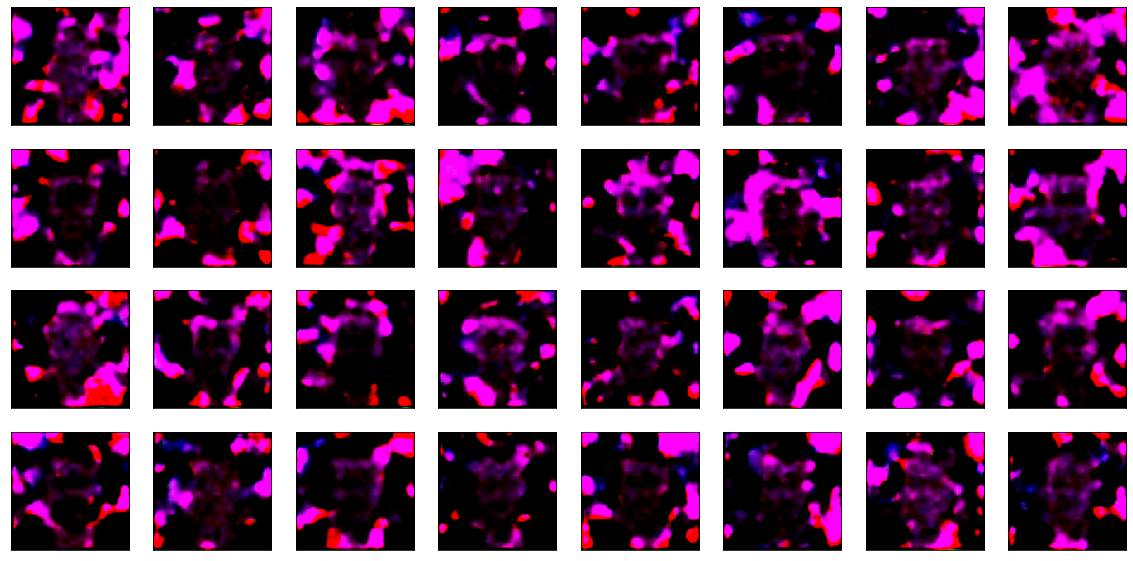

In [62]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_digits(syntetic_images)

## Интерполяция в латентном пространстве

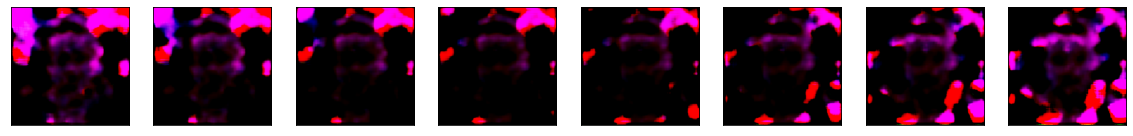

In [63]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
plot_digits(syntetic_images)

Из-за незначительного времни обучения получиась ерунда, но можно сказать что кое-где можно различить очертания лиц